In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data processing
import pandas as pd
import numpy as np
import nltk

# Modeling
import tensorflow as tf

#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Features
from sklearn.feature_extraction.text import TfidfVectorizer

#CLF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
# from sklearn.linear_model import LinearRegression

#time xd
from time import time

# text processing
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
import string
from nltk.corpus import stopwords

#graficar
import matplotlib.pyplot as plt

import locale
locale.getpreferredencoding = lambda: "UTF-8"
#stopwords and lemmatizer
!python -m spacy download es_core_news_sm
nltk.download('punkt')
nltk.download('stopwords')
import spacy

2023-04-24 23:43:11.754044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 44.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!unzip /content/drive/MyDrive/Mental-RISK/Archivo/Archivo.zip

Archive:  /content/drive/MyDrive/Mental-RISK/Archivo/Archivo.zip
  inflating: data_task1a_round_1.csv  
  inflating: data_task1a_round_2.csv  
  inflating: data_task1a_round_3.csv  
  inflating: data_task1a_round_4.csv  
  inflating: data_task1a_round_5.csv  
  inflating: data_task1a_round_6.csv  
  inflating: data_task1a_round_7.csv  
  inflating: data_task1a_round_8.csv  
  inflating: data_task1a_round_9.csv  
  inflating: data_task1a_round_10.csv  
  inflating: data_task1a_round_11.csv  
  inflating: data_task1a_round_12.csv  
  inflating: data_task1a_round_13.csv  
  inflating: data_task1a_round_14.csv  
  inflating: data_task1a_round_15.csv  
  inflating: data_task1a_round_16.csv  
  inflating: data_task1a_round_17.csv  
  inflating: data_task1a_round_18.csv  
  inflating: data_task1a_round_19.csv  
  inflating: data_task1a_round_20.csv  
  inflating: data_task1a_round_21.csv  
  inflating: data_task1a_round_22.csv  
  inflating: data_task1a_round_23.csv  
  inflating: data_task1a

# Funciones

In [4]:
# stopwords (sacando mia)
result = set(stopwords.words('spanish'))
print("List of stopwords in spanish:")
print (len(result))
print("\nOmit - 'mía':")
stop_words = set(stopwords.words('spanish')) - set(['mía'])
print("\nList of fresh stopwords in spanish:")
print (len(stop_words))

# lemmatizer
nlp = spacy.load("es_core_news_sm")

List of stopwords in spanish:
313

Omit - 'mía':

List of fresh stopwords in spanish:
312


In [5]:
def lemmatize(dF):
  '''
  Lemmatize column 'text' of a dataframe
  '''
  nlp = spacy.load("es_core_news_sm")
  lemma_text_list = []
  for doc in nlp.pipe(dF["text"]):
      lemma_text_list.append(" ".join(token.lemma_ for token in doc))

  dF.loc[dF.index,"text"] = lemma_text_list
  return dF

In [6]:
def lemmatize_list(list_to_lem):
  '''
  Lemmatize column 'text' of a dataframe
  '''
  nlp = spacy.load("es_core_news_sm")
  lemma_text_list = []
  for doc in nlp.pipe(list_to_lem):
      lemma_text_list.append(" ".join(token.lemma_ for token in doc))

  # dF.loc[dF.index,"text"] = lemma_text_list
  return pd.DataFrame(lemma_text_list, columns = ['text'])

In [7]:
def read_rounds(task , n_rounds, original_path = ""):
  rounds = []
  for n_round in range(1, n_rounds+1):
    # print(original_path + 'data_task' + task + '_round_' + str(n_round) + '.csv') #para chequear el orden
    round = pd.read_csv(original_path + 'data_task' + task + '_round_' + str(n_round) + '.csv', sep = ',')
    rounds.append(round)
  return rounds

In [8]:
def rounds_partition(rounds, train_index):
  ''''
  rounds: lista de rounds
  train_index: indices del conjunto de entrenamiento

  out: rounds_train, rounds_test
  '''
  rounds_train = []
  rounds_test = []
  for round in rounds:
    rounds_train.append(round.iloc[train_index])
    test_round = round[~round.index.isin(train_index)].reset_index(drop = True)
    rounds_test.append(test_round) #complemento de los indices de train
  return rounds_train, rounds_test

In [9]:
def add_messages(rounds):
  '''
  rounds: lista de rounds

  out: dF con los mensajes sumados en la columnas text y la etiqueta en label
  '''
  # all_messages = pd.DataFrame([], columns = ['text', 'label'])
  all_messages = rounds[0]
  for round in rounds[1:]:
    all_messages.text.str.cat(round.text, sep = " ", na_rep = "")
  # all_messages['label'] = rounds[0]['label']
  return all_messages

In [10]:
def evaluate_rounds(test_rounds, pipeline):
  '''
  Predecir cada round, considera lemmatización de la frase

  out: lista de diccionarios de classification reports
  '''
  clf_reports = []
  y_test = np.ravel(test_rounds[0]['label'])
  for round in test_rounds:
    # round = lemmatize(round)
    # text_col = pd.DataFrame(round['text'])
    y_pred = pipeline.predict(round['text'])
    clf_reports.append(classification_report(y_pred, y_test, output_dict = True))
    # print(classification_report(y_pred, y_test))

  return clf_reports

In [11]:
def get_metrics(clf_reports):
  '''
  Plot the specified metric
  clf_reports: list clf reports
  
  out: dF con lista de cada submétrica

  key1: ['0', '1', 'accuracy', 'macro avg', 'weighted avg']
  key2: ['precision', 'recall', 'f1-score', 'support']
  '''
  dF_key1 = pd.DataFrame.from_dict(clf_reports)
  key1 = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']
  key2 = ['precision', 'recall', 'f1-score', 'support']
  dict_metrics = {}
  for key in key1:
    # print(key)
    if key == 'accuracy':
      dict_metrics[key] = dF_key1[key]
    else:  
      dict_metrics[key] = pd.DataFrame.from_records(dF_key1[key])

  return dict_metrics


In [12]:
def plot_metric(list_dict_metric, list_clf_names, key, subkey):
  '''
  lista_dict_metric: lista de diccionarios con las métrica
  list_clf_names: nombres de los clasificadores
  key: primera key de la métrica
  subkey: segunda key del diccionario
  '''
  metric = []
  for dict_metric in list_dict_metric:
    if key == 'accuracy':
      metric.append(dict_metric[key])
      subkey = ""
    else:
      metric.append(dict_metric[key][subkey])

  for i in range(len(list_clf_names)):
    plt.plot( metric[i], label = list_clf_names[i])
  plt.title('Metric: ' + key + '-' + subkey )
  plt.xlabel('N message')
  plt.ylabel(key + '-' + subkey)
  plt.legend(loc = "lower right")
  plt.grid()


# Task 1

## Exploración de mensajes

## 1a

Particionan los datos

In [13]:
rounds_1a = read_rounds('1a', 50)

df_y = rounds_1a[49]["label"]
df_X = rounds_1a[49]

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=42, stratify=df_y
)

# X_train = lemmatize(X_train)

train_rounds, test_rounds = rounds_partition(rounds_1a, X_train.index)

In [15]:
column_to_vectorize = "text"

lemmatize = FunctionTransformer(lemmatize_list)

tfidf = TfidfVectorizer(stop_words= list(stop_words) + ['q'], 
                        ngram_range = (1,3)
                        )

clmn = ColumnTransformer([("tfidf", tfidf, column_to_vectorize)
                          ],
                         remainder="drop")

linear_svc_pipe = Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("linear_SVM", SVC(kernel="linear"))
        ])

svc_pipe = Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("SVM", SVC(kernel="rbf"))
        ])


mnb_pipe = Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("MultiNB", MultinomialNB(alpha=0.01))
        ])

knn_pipe =Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("KNN", KNeighborsClassifier())
        ])


xgb_pipe = Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("xgb", xgb.XGBClassifier(objective="binary:logistic", random_state=42)) 
        ])

In [183]:
lemmatize = FunctionTransformer(lemmatize_list)
linear_svc_pipe = Pipeline(
    [   
        ("lemma",  lemmatize ),
        ('tfidf', clmn),
        ("linear_SVM", SVC(kernel="linear"))
        ])

In [184]:
X_train = train_rounds[49]['text']
y_train = train_rounds[49]['label']
X_test = X_test#['text']

linear_svc = linear_svc_pipe.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
print('Resultados Linear SVC:')
print(classification_report(y_pred, y_test))

# rbf_svc = svc_pipe.fit(X_train, y_train)
# y_pred = rbf_svc.predict(X_test)
# print('Resultados RBF SVC')
# print(classification_report(y_pred, y_test))

# mnb_clf = mnb_pipe.fit(X_train, y_train)
# y_pred = mnb_clf.predict(X_test)
# print('Resultados MultinomialNB:')
# print(classification_report(y_pred, y_test))

# knn = knn_pipe.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# print('Resultados KNN')
# print(classification_report(y_pred, y_test))

Resultados Linear SVC:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.87      1.00      0.93        13

    accuracy                           0.94        35
   macro avg       0.93      0.95      0.94        35
weighted avg       0.95      0.94      0.94        35



In [16]:
X_train = train_rounds[49]['text']
y_train = train_rounds[49]['label']
# X_test = X_test['text']

# linear_svc = linear_svc_pipe.fit(X_train, y_train)
# linear_svc_reports = evaluate_rounds(test_rounds, linear_svc)
# linear_svc_metrics =  get_metrics(linear_svc_reports)

# rbf_svc = svc_pipe.fit(X_train, y_train)
# rbf_svc_reports = evaluate_rounds(test_rounds, rbf_svc)
# rbf_svc_metrics =  get_metrics(rbf_svc_reports)

mnb_clf = mnb_pipe.fit(X_train, y_train)
mnb_clf_reports = evaluate_rounds(test_rounds, mnb_clf)
mnb_clf_metrics =  get_metrics(mnb_clf_reports)

# knn = knn_pipe.fit(X_train, y_train)
# knn_clf_reports = evaluate_rounds(test_rounds, knn)
# knn_clf_metrics =  get_metrics(knn_clf_reports)

# xgb = xgb_pipe.fit(X_train, y_train)
# xgb_clf_reports = evaluate_rounds(test_rounds, xgb)
# xgb_clf_metrics =  get_metrics(xgb_clf_reports)

In [188]:
list_dict_metric = [linear_svc_metrics, rbf_svc_metrics, mnb_clf_metrics, knn_clf_metrics, xgb_clf_metrics]
list_clf_names = ['Linear SVC', 'RBF SVC', 'MultinomialNB', 'KNN', 'XGB']


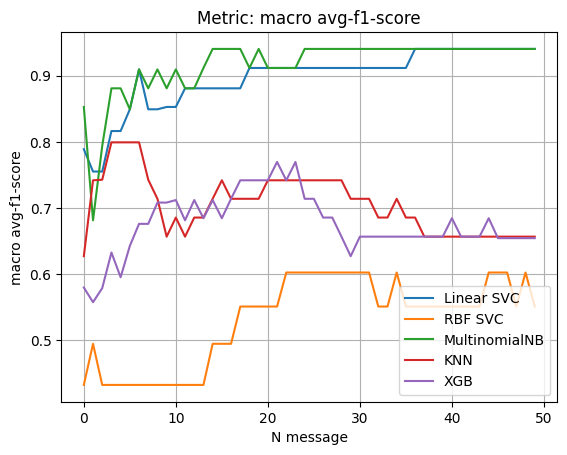

In [189]:
key = 'macro avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

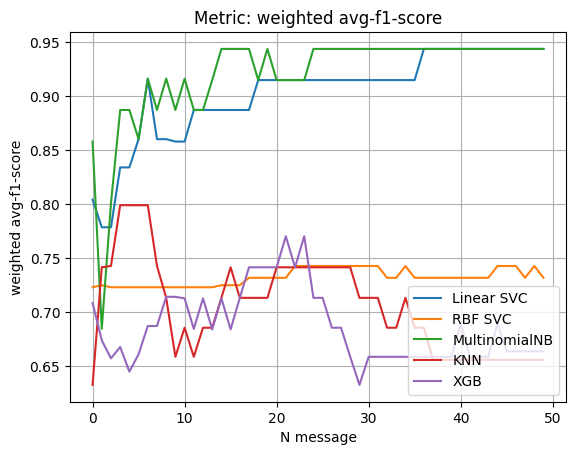

In [190]:
key = 'weighted avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

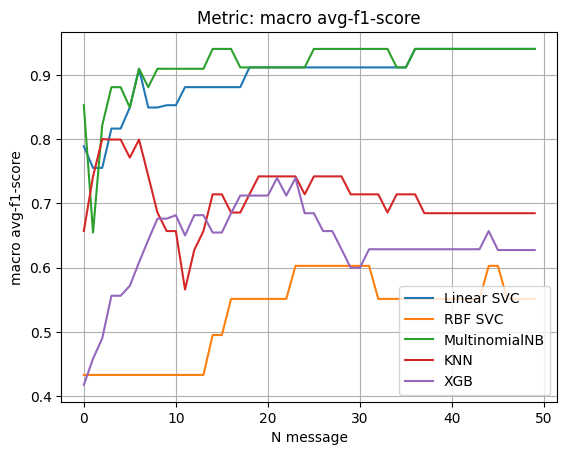

In [16]:
key = 'macro avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

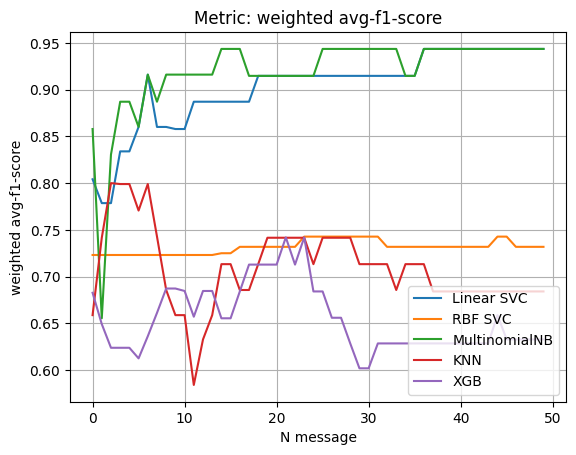

In [17]:
key = 'weighted avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

In [194]:
mnb_clf

Pipeline(steps=[('lemma',
                 FunctionTransformer(func=<function lemmatize_list at 0x7f02b0c1e040>)),
                ('tfidf',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  stop_words=['tendremos',
                                                                              'nuestro',
                                                                              'son',
                                                                              'hubiera',
                                                                              'estado',
                                                                              'otros',
                                                                              'serás',
                                                                              'sentido',
                                                                              'porque',
                                                                              'estadas',
                                                                              'esa',
                                                                              'unos',
                                                                              'estará',
                                                                              'ella',
                                                                              'tendría',
                                                                              'tengamos',
                                                                              'hubieran',
                                                                              'míos',
                                                                              'esos',
                                                                              'estuviesen',
                                                                              'he',
                                                                              'te',
                                                                              'tengas',
                                                                              'estaríais',
                                                                              'estados',
                                                                              'erais',
                                                                              'poco',
                                                                              'eso',
                                                                              'y',
                                                                              'sobre', ...]),
                                                  'text')])),
                ('MultiNB', MultinomialNB(alpha=0.01))])

In [17]:
import pickle

pickle.dump(mnb_clf, open('multiNB.pkl', 'wb'))

In [18]:
pickled_model = pickle.load(open('multiNB.pkl', 'rb'))

In [202]:
pickled_model

Pipeline(steps=[('lemma',
                 FunctionTransformer(func=<function lemmatize_list at 0x7f02b0c1e040>)),
                ('tfidf',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  stop_words=['tendremos',
                                                                              'nuestro',
                                                                              'son',
                                                                              'hubiera',
                                                                              'estado',
                                                                              'otros',
                                                                              'serás',
                                                                              'sentido',
                                                                              'porque',
                                                                              'estadas',
                                                                              'esa',
                                                                              'unos',
                                                                              'estará',
                                                                              'ella',
                                                                              'tendría',
                                                                              'tengamos',
                                                                              'hubieran',
                                                                              'míos',
                                                                              'esos',
                                                                              'estuviesen',
                                                                              'he',
                                                                              'te',
                                                                              'tengas',
                                                                              'estaríais',
                                                                              'estados',
                                                                              'erais',
                                                                              'poco',
                                                                              'eso',
                                                                              'y',
                                                                              'sobre', ...]),
                                                  'text')])),
                ('MultiNB', MultinomialNB(alpha=0.01))])

### Optimización de parámetros

## 1b

Tengo que cambiar a regresores los pipelines

In [ ]:
rounds_1b = read_rounds('1b', 50)

df_y = rounds_1b[49]["label"]
df_X = rounds_1b[49]

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=42, stratify=df_y
)

# X_train = lemmatize(X_train)

train_rounds, test_rounds = rounds_partition(rounds_1b, X_train.index)

In [ ]:
column_to_vectorize = "text"

tfidf = TfidfVectorizer(stop_words= list(stop_words) + ['q'], 
                        ngram_range = (1,3)
                        )

clmn = ColumnTransformer([("tfidf", tfidf, column_to_vectorize)
                          ],
                         remainder="drop")

test_pipe = Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("linear_SVM", SVC(kernel="linear"))
        ])

linear_svc_pipe = Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("linear_SVM", SVC(kernel="linear"))
        ])

svc_pipe = Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("SVM", SVC(kernel="rbf"))
        ])


mnb_pipe = Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("MultiNB", MultinomialNB(alpha=0.01))
        ])

knn_pipe =Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("KNN", KNeighborsClassifier())
        ])


xgb_pipe = Pipeline(
    [   
        ("lemma",  pipelinize(spacy_tokenizer_lemmatizer) ),
        ('tfidf', clmn),
        ("xgb", xgb.XGBClassifier(objective="binary:logistic", random_state=42)) 
        ])

In [ ]:
linear_svc = linear_svc_pipe.fit(X_train, y_train)
linear_svc_reports = evaluate_rounds(test_rounds, linear_svc)
linear_svc_metrics =  get_metrics(linear_svc_reports)

rbf_svc = svc_pipe.fit(X_train, y_train)
rbf_svc_reports = evaluate_rounds(test_rounds, rbf_svc)
rbf_svc_metrics =  get_metrics(rbf_svc_reports)

mnb_clf = mnb_pipe.fit(X_train, y_train)
mnb_clf_reports = evaluate_rounds(test_rounds, mnb_clf)
mnb_clf_metrics =  get_metrics(mnb_clf_reports)

knn = knn_pipe.fit(X_train, y_train)
knn_clf_reports = evaluate_rounds(test_rounds, knn)
knn_clf_metrics =  get_metrics(knn_clf_reports)

xgb = xgb_pipe.fit(X_train, y_train)
xgb_clf_reports = evaluate_rounds(test_rounds, xgb)
xgb_clf_metrics =  get_metrics(xgb_clf_reports)

# Task 2

## 2a

In [19]:
rounds_2a = read_rounds('2a', 100)

df_y = rounds_2a[99]["label"]
df_X = rounds_2a[99]

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=42, stratify=df_y
)

# X_train = lemmatize(X_train)

train_rounds, test_rounds = rounds_partition(rounds_2a, X_train.index)

In [20]:
X_train = train_rounds[99]['text']
X_train.reset_index(drop = True, inplace=True)
y_train = train_rounds[99]['label']
y_train.reset_index(drop = True, inplace=True)

In [21]:
# linear_svc = linear_svc_pipe.fit(X_train, y_train)
# linear_svc_reports = evaluate_rounds(test_rounds, linear_svc)
# linear_svc_metrics =  get_metrics(linear_svc_reports)

# rbf_svc = svc_pipe.fit(X_train, y_train)
# rbf_svc_reports = evaluate_rounds(test_rounds, rbf_svc)
# rbf_svc_metrics =  get_metrics(rbf_svc_reports)

mnb_clf = mnb_pipe.fit(X_train, y_train)
mnb_clf_reports = evaluate_rounds(test_rounds, mnb_clf)
mnb_clf_metrics =  get_metrics(mnb_clf_reports)

# knn = knn_pipe.fit(X_train, y_train)
# knn_clf_reports = evaluate_rounds(test_rounds, knn)
# knn_clf_metrics =  get_metrics(knn_clf_reports)

# xgb = xgb_pipe.fit(X_train, y_train)
# xgb_clf_reports = evaluate_rounds(test_rounds, xgb)
# xgb_clf_metrics =  get_metrics(xgb_clf_reports)

In [215]:
linear_svc_metrics['0']['f1-score']

0     0.363636
1     0.400000
2     0.454545
3     0.454545
4     0.538462
        ...   
95    0.689655
96    0.689655
97    0.689655
98    0.689655
99    0.689655
Name: f1-score, Length: 100, dtype: float64

In [ ]:
list_dict_metric = [linear_svc_metrics, rbf_svc_metrics, mnb_clf_metrics, knn_clf_metrics, xgb_clf_metrics]
list_clf_names = ['Linear SVC', 'RBF SVC', 'MultinomialNB', 'KNN', 'XGB']

key = 'macro avg'
subkey = 'f1-score'

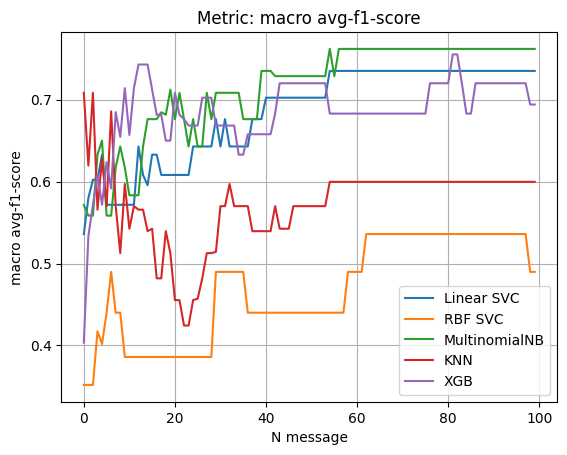

In [ ]:
key = 'macro avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

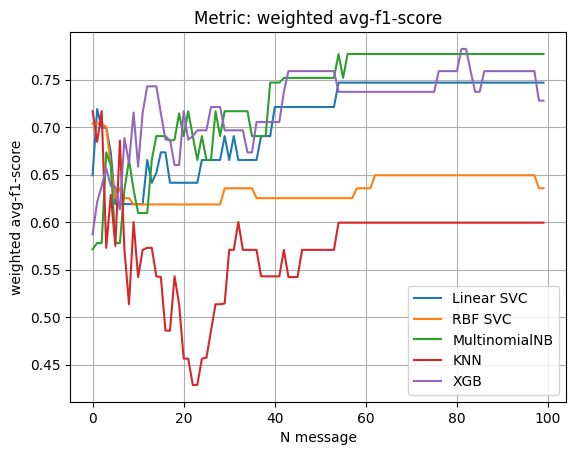

In [ ]:
key = 'weighted avg'
subkey = 'f1-score'

plot_metric(list_dict_metric, list_clf_names, key, subkey)

In [22]:
pickle.dump(mnb_clf, open('multiNB_2a.pkl', 'wb'))

In [23]:
pickled_model = pickle.load(open('multiNB_2a.pkl', 'rb'))

In [24]:
pickled_model

Pipeline(steps=[('lemma',
                 FunctionTransformer(func=<function lemmatize_list at 0x7f31316c3160>)),
                ('tfidf',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  stop_words=['estadas',
                                                                              'también',
                                                                              'fueron',
                                                                              'estarán',
                                                                              'estar',
                                                                              'tú',
                                                                              'seamos',
                                                                              'nosotros',
                                                                              'habrá',
                                                                              'habíamos',
                                                                              'sus',
                                                                              'somos',
                                                                              'tendrías',
                                                                              'estuvierais',
                                                                              'estuviésemos',
                                                                              'fueran',
                                                                              'le',
                                                                              'fuimos',
                                                                              'estoy',
                                                                              'e',
                                                                              'fuésemos',
                                                                              'tuvimos',
                                                                              'fue',
                                                                              'nada',
                                                                              'con',
                                                                              'tendrían',
                                                                              'soy',
                                                                              'tengan',
                                                                              'seas',
                                                                              'habido', ...]),
                                                  'text')])),
                ('MultiNB', MultinomialNB(alpha=0.01))])

## 2b

In [ ]:
rounds_2b = read_rounds('2b', 100)

## 2c

In [ ]:
rounds_2c = read_rounds('2c', 100)

## 2d

In [ ]:
rounds_2d = read_rounds('2d', 100)